# Introduction

This notebook attempts to improve the score from `yu_roger-10906675-week1_randcv_xgb_69051.ipynb` of 0.69051 (model `randomised_xgb.joblib`) by using tuning the `scale_pos_weight` parameter. Previous experiment results have shown that the predictions are heavily weighted to the positive class, with almost no predictions of the negative class. Reducing the `scale_pos_weight` parameter in the XGB Classifier should address this.

## Summary
* the [best `scale_pos_weight`](#Best-scale_pos_weight) value was 0.1 and it improved the validation AUC slightly from 0.699 to 0.702
* ✔ the [results of test AUC](#results-of-test-AUC) was an improvement of the [baseline score](#Baseline Score); from 0.69051 to 0.69450
* [finer grid search of the `scale_pos_weight`](#Further-experiments:-finer-grids) shows that 0.1 is still the optimal value

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from scipy import stats
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt
from typing import Dict
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import find_dotenv, load_dotenv
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

from src.data.make_dataset import load_sets, save_sets, save_predictions
from src.models.null import NullModel
from src.visualization.visualize import classification_reports, classification_reports_2
from src.visualization.visualize import plot_pie, create_feature_importance_df, plot_feature_importances


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
load_dotenv(find_dotenv())
api = KaggleApi()
api.authenticate()

In [4]:
competition = os.environ['COMPETITION']

# Set up directories

In [5]:
project_dir = Path.cwd().parent.parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'
processed_data_dir = data_dir / 'processed'
models_dir = project_dir / 'models'

# Load data

In [6]:
X_train, X_val, y_train, y_val, X_test = load_sets(interim_data_dir)
X_train_lim, X_val_lim, y_train_lim, y_val_lim, X_test_lim = load_sets(interim_data_dir, suffix='top_8_features')
test_id = pd.read_csv(interim_data_dir / 'test_id.csv')

# Baseline

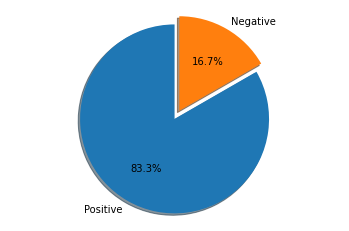

In [7]:
plot_pie(y_train)

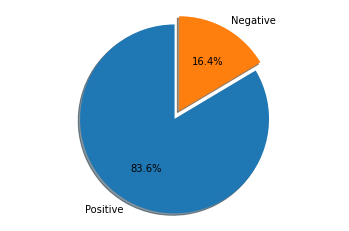

In [8]:
plot_pie(y_val)

## Baseline Score

The baseline is simply the best from the previous attempt of 0.69051.

# Load best model

The best model so far is `randomised_xgb.joblib` with a test AUC of 0.69051.

In [9]:
random_cv = load(models_dir / 'randomised_xgb.joblib')

In [10]:
random_cv

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            eval_metric='logloss',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            intera

In [11]:
best_model = random_cv.best_estimator_

# Find `best_ntree_limit`

The score on the best model did not use the `early_stopping`, hence, didn't use the `best_ntree_limit`. This section finds the `best_ntree_limit` and uses it in the predictions.

## Summary
* Using early stopping on the best model improves the overfitting issue from a difference of 0.127 AUC to 0.053

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[  42 1026]
 [   1 5331]]
Accuracy:  0.83953125
AUC:  0.8277863005077111
              precision    recall  f1-score   support

           0       0.98      0.04      0.08      1068
           1       0.84      1.00      0.91      5332

    accuracy                           0.84      6400
   macro avg       0.91      0.52      0.49      6400
weighted avg       0.86      0.84      0.77      6400



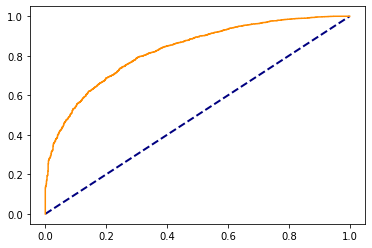

In [12]:
classification_reports(best_model, X_train, y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[   3  260]
 [   2 1335]]
Accuracy:  0.83625
AUC:  0.7007032940781672
              precision    recall  f1-score   support

           0       0.60      0.01      0.02       263
           1       0.84      1.00      0.91      1337

    accuracy                           0.84      1600
   macro avg       0.72      0.50      0.47      1600
weighted avg       0.80      0.84      0.76      1600



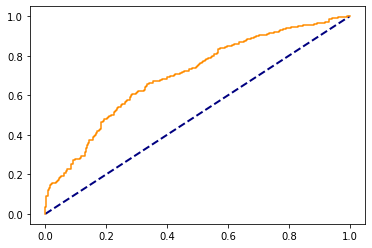

In [13]:
classification_reports(best_model, X_val, y_val)

The training AUC is 0.828, while the validation AUC is 0.701; a difference of 0.127. This shows that the model is overfit.

## Separate the classifier from the pipe

[sklearn.pipeline.Pipeline](#https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) does not accept fit parameters, which is required to conduct early stopping. So the pipe will omit the classifier and just transform the data. This is required for the validation set because the transformation doesn't go all the way to the fit step.

In [14]:
pipe = Pipeline(random_cv.best_estimator_.steps[:-1])
X_val_trans = pipe.transform(X_val)

In [15]:
fit_params = {'classifier__eval_set': [(X_val_trans, y_val)],
              'classifier__eval_metric': 'auc',
              'classifier__early_stopping_rounds': 10,
              'classifier__verbose': True}
best_model.fit(X_train, y_train, **fit_params)

[0]	validation_0-auc:0.54107
[1]	validation_0-auc:0.57336
[2]	validation_0-auc:0.57460
[3]	validation_0-auc:0.57946
[4]	validation_0-auc:0.64009
[5]	validation_0-auc:0.63276
[6]	validation_0-auc:0.66704
[7]	validation_0-auc:0.66251
[8]	validation_0-auc:0.67700
[9]	validation_0-auc:0.67144
[10]	validation_0-auc:0.68072
[11]	validation_0-auc:0.68662
[12]	validation_0-auc:0.68042
[13]	validation_0-auc:0.68764
[14]	validation_0-auc:0.69032
[15]	validation_0-auc:0.68766
[16]	validation_0-auc:0.69311
[17]	validation_0-auc:0.69890
[18]	validation_0-auc:0.69418
[19]	validation_0-auc:0.69653
[20]	validation_0-auc:0.69561
[21]	validation_0-auc:0.69598
[22]	validation_0-auc:0.69282
[23]	validation_0-auc:0.69566
[24]	validation_0-auc:0.69459
[25]	validation_0-auc:0.69458
[26]	validation_0-auc:0.69693
[27]	validation_0-auc:0.69514


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=8)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.590700201239684,
                               eval_metric='logloss', gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.020933095390929836,
                               max_delta_step=0, max_depth=5,
                               min_child_weight=2, missing=nan,
                               monotone_constraints='()', n_estimators=184,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.6028987933998539,
               

In [16]:
best_ntree_limit = best_model['classifier'].best_ntree_limit
best_ntree_limit

18

Note that if `best_ntree_limit` is already set, then the `.predict` method uses this parameter by default.

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[  14 1054]
 [   0 5332]]
Accuracy:  0.8353125
AUC:  0.7543304365417196
              precision    recall  f1-score   support

           0       1.00      0.01      0.03      1068
           1       0.83      1.00      0.91      5332

    accuracy                           0.84      6400
   macro avg       0.92      0.51      0.47      6400
weighted avg       0.86      0.84      0.76      6400



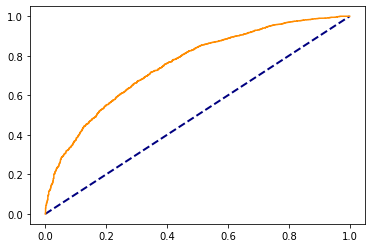

In [17]:
classification_reports(best_model, X_train, y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[   1  262]
 [   0 1337]]
Accuracy:  0.83625
AUC:  0.6989031115004081
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       263
           1       0.84      1.00      0.91      1337

    accuracy                           0.84      1600
   macro avg       0.92      0.50      0.46      1600
weighted avg       0.86      0.84      0.76      1600



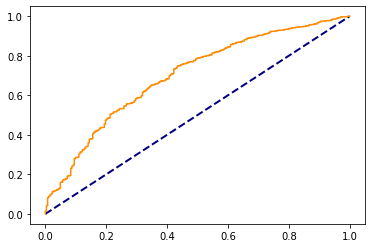

In [18]:
classification_reports(best_model, X_val, y_val)

The training AUC is 0.754, while the validation AUC is 0.699; a difference of 0.053. This shows that the model is slightly less overfit.

# Tuning `scale_pos_weight` in `GridSearchCV`

In [21]:
fit_params = {'classifier__eval_set': [(X_val_trans, y_val)],
              'classifier__eval_metric': 'auc',
              'classifier__early_stopping_rounds': 10,
              'classifier__verbose': True}

search_space = {'classifier__scale_pos_weight': np.arange(0, 1, 0.1)}

grid_cv = GridSearchCV(estimator=best_model,
                       param_grid=search_space,
                       scoring='roc_auc',
                       n_jobs=-1,
                       cv=5,
                       refit=True,
                       verbose=2)

grid_cv.fit(X_train, y_train, **fit_params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0]	validation_0-auc:0.54985
[1]	validation_0-auc:0.57177
[2]	validation_0-auc:0.56394
[3]	validation_0-auc:0.57011
[4]	validation_0-auc:0.62993
[5]	validation_0-auc:0.62053
[6]	validation_0-auc:0.65304
[7]	validation_0-auc:0.65245
[8]	validation_0-auc:0.67007
[9]	validation_0-auc:0.66649
[10]	validation_0-auc:0.67644
[11]	validation_0-auc:0.68461
[12]	validation_0-auc:0.68081
[13]	validation_0-auc:0.68792
[14]	validation_0-auc:0.69068
[15]	validation_0-auc:0.68556
[16]	validation_0-auc:0.68954
[17]	validation_0-auc:0.69354
[18]	validation_0-auc:0.69043
[19]	validation_0-auc:0.69302
[20]	validation_0-auc:0.69234
[21]	validation_0-auc:0.69481
[22]	validation_0-auc:0.69169
[23]	validation_0-auc:0.69452
[24]	validation_0-auc:0.69483
[25]	validation_0-auc:0.69409
[26]	validation_0-auc:0.69628
[27]	validation_0-auc:0.69459
[28]	validation_0-auc:0.69567
[29]	validation_0-auc:0.69429
[30]	validation_0-auc:0.69626
[31]	validation_0-a

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=8)),
                                       ('classifier',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=0.590700201239684,
                                                      eval_metric='logloss',
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.0209330953...
             

In [22]:
grid_cv.best_estimator_['classifier'].get_booster().best_ntree_limit

27

## Best `scale_pos_weight`

From the `GridSearchCV`, searching in steps of 0.1. The best value for `scale_pos_weight` is 0.5.

In [23]:
grid_cv.best_params_

{'classifier__scale_pos_weight': 0.5}

 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[  53 1015]
 [  16 5316]]
Accuracy:  0.83890625
AUC:  0.7719218252596858
              precision    recall  f1-score   support

           0       0.77      0.05      0.09      1068
           1       0.84      1.00      0.91      5332

    accuracy                           0.84      6400
   macro avg       0.80      0.52      0.50      6400
weighted avg       0.83      0.84      0.78      6400



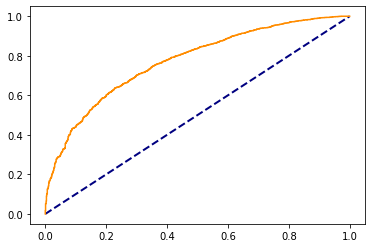

In [24]:
classification_reports(grid_cv, X_train, y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[   5  258]
 [   6 1331]]
Accuracy:  0.835
AUC:  0.6962824665629594
              precision    recall  f1-score   support

           0       0.45      0.02      0.04       263
           1       0.84      1.00      0.91      1337

    accuracy                           0.83      1600
   macro avg       0.65      0.51      0.47      1600
weighted avg       0.77      0.83      0.77      1600



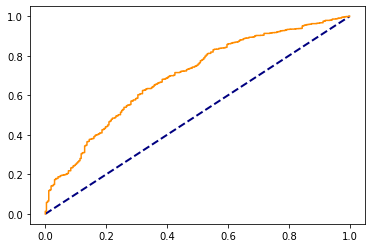

In [25]:
classification_reports(grid_cv, X_val, y_val)

There is a slight decrease to the validation AUC from 0.696 to 0.702. The predictions are still predominantly positive.

# Finer grid

Now that we know that the optimal `scale_pos_weight` is around 0.5, using a coarse grid with a step size of 0.1. This section will search more with more finely grained stepsize of 0.01 in the range [0.4, 0.6].

In [26]:
fit_params = {'classifier__eval_set': [(X_val_trans, y_val)],
              'classifier__eval_metric': 'auc',
              'classifier__early_stopping_rounds': 10,
              'classifier__verbose': True}

search_space = {'classifier__scale_pos_weight': np.arange(0.4, 0.6, 0.01)}
grid_cv_fine = GridSearchCV(estimator=grid_cv.best_estimator_,
                            param_grid=search_space,
                            scoring='roc_auc',
                            n_jobs=-1,
                            cv=5,
                            refit=True,
                            verbose=3)

grid_cv_fine.fit(X_train, y_train, **fit_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[0]	validation_0-auc:0.54985
[1]	validation_0-auc:0.56878
[2]	validation_0-auc:0.56193
[3]	validation_0-auc:0.56784
[4]	validation_0-auc:0.62688
[5]	validation_0-auc:0.61818
[6]	validation_0-auc:0.65030
[7]	validation_0-auc:0.64944
[8]	validation_0-auc:0.66603
[9]	validation_0-auc:0.66298
[10]	validation_0-auc:0.67342
[11]	validation_0-auc:0.68059
[12]	validation_0-auc:0.67619
[13]	validation_0-auc:0.68376
[14]	validation_0-auc:0.68700
[15]	validation_0-auc:0.68167
[16]	validation_0-auc:0.68773
[17]	validation_0-auc:0.69212
[18]	validation_0-auc:0.68907
[19]	validation_0-auc:0.69212
[20]	validation_0-auc:0.69136
[21]	validation_0-auc:0.69362
[22]	validation_0-auc:0.69007
[23]	validation_0-auc:0.69251
[24]	validation_0-auc:0.69264
[25]	validation_0-auc:0.69236
[26]	validation_0-auc:0.69349
[27]	validation_0-auc:0.69185
[28]	validation_0-auc:0.69309
[29]	validation_0-auc:0.69181
[30]	validation_0-auc:0.69366
[31]	validation_0-

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=8)),
                                       ('classifier',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=0.590700201239684,
                                                      eval_metric='logloss',
                                                      gamma=0, gpu_id=-1,
                                                      importance_type='gain',
                                                      interaction_constraints='',
                                                      learning_rate=0.0209330953...
             

In [27]:
grid_cv_fine.best_estimator_['classifier'].get_booster().best_ntree_limit

52

In [28]:
grid_cv_fine.best_params_

{'classifier__scale_pos_weight': 0.5500000000000002}

The best `scale_pos_weight` is 0.55.

In [29]:
pd.DataFrame(grid_cv_fine.cv_results_).sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.955001,0.331665,0.010800,0.000399,0.55,{'classifier__scale_pos_weight': 0.55000000000...,0.654468,0.691316,0.699159,0.676115,0.670508,0.678313,0.015735,1
16,0.971605,0.371350,0.012595,0.003931,0.56,{'classifier__scale_pos_weight': 0.56000000000...,0.655295,0.688361,0.698690,0.675199,0.670758,0.677661,0.014904,2
17,0.977998,0.375702,0.011399,0.001019,0.57,{'classifier__scale_pos_weight': 0.57000000000...,0.655422,0.688044,0.698304,0.676172,0.669259,0.677440,0.014840,3
10,0.794999,0.289585,0.010200,0.000749,0.5,{'classifier__scale_pos_weight': 0.50000000000...,0.655810,0.686179,0.697428,0.667536,0.677728,0.676936,0.014427,4
14,0.821201,0.259978,0.010000,0.001674,0.54,{'classifier__scale_pos_weight': 0.54000000000...,0.656100,0.691008,0.697686,0.668369,0.671050,0.676842,0.015302,5
3,0.827600,0.284167,0.010600,0.001020,0.43,{'classifier__scale_pos_weight': 0.43000000000...,0.656390,0.683558,0.695571,0.668259,0.678968,0.676550,0.013356,6
4,0.797198,0.301072,0.010402,0.001020,0.44,{'classifier__scale_pos_weight': 0.44000000000...,0.657064,0.679891,0.696073,0.670556,0.678675,0.676452,0.012747,7
18,0.832198,0.215013,0.010401,0.001201,0.58,{'classifier__scale_pos_weight': 0.58000000000...,0.651775,0.687382,0.698300,0.668242,0.673734,0.675887,0.015994,8
13,0.773200,0.276148,0.011801,0.001939,0.53,{'classifier__scale_pos_weight': 0.53000000000...,0.656038,0.687914,0.696843,0.668597,0.669684,0.675815,0.014624,9
11,0.753199,0.256869,0.010599,0.001201,0.51,{'classifier__scale_pos_weight': 0.51000000000...,0.656896,0.686744,0.696941,0.667137,0.669640,0.675472,0.014398,10


 class 1 :  5332
 class 0 :  1068
Confusion Matrix: 
 [[  54 1014]
 [  12 5320]]
Accuracy:  0.8396875
AUC:  0.7836622076867532
              precision    recall  f1-score   support

           0       0.82      0.05      0.10      1068
           1       0.84      1.00      0.91      5332

    accuracy                           0.84      6400
   macro avg       0.83      0.52      0.50      6400
weighted avg       0.84      0.84      0.78      6400



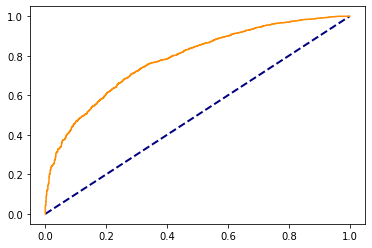

In [30]:
classification_reports(grid_cv_fine, X_train, y_train)

 class 1 :  1337
 class 0 :  263
Confusion Matrix: 
 [[   5  258]
 [   5 1332]]
Accuracy:  0.835625
AUC:  0.6990709010297727
              precision    recall  f1-score   support

           0       0.50      0.02      0.04       263
           1       0.84      1.00      0.91      1337

    accuracy                           0.84      1600
   macro avg       0.67      0.51      0.47      1600
weighted avg       0.78      0.84      0.77      1600



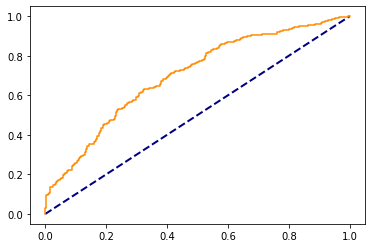

In [31]:
classification_reports(grid_cv_fine, X_val, y_val)

## Result

This has increased the the validation AUC slightly from 0.6989 to 0.6991. However, the predictions are still predominantly of the positive class.

## Save model

In [32]:
model_name = '10906675_xgb_es_spw.joblib'
models_dir / model_name

WindowsPath('D:/Projects/assignment_1/models/10906675_xgb_es_spw.joblib')

In [33]:
model_name = '10906675_xgb_es_spw.joblib'
dump(grid_cv_fine.best_estimator_, models_dir / model_name)

['D:\\Projects\\assignment_1\\models\\10906675_xgb_es_spw.joblib']

# Prediction on test set

In [34]:
probs = grid_cv_fine.best_estimator_.predict_proba(X_test)[:, 1]

In [35]:
probs

array([0.65319955, 0.65564203, 0.72314936, ..., 0.60709983, 0.72595614,
       0.6344749 ], dtype=float32)

In [36]:
path = processed_data_dir / f'probs_{model_name}.csv'
save_predictions(probs, 'TARGET_5Yrs', test_id, path)

## Submit predictions

# Results of test AUC

The test AUC is 0.69390.